In [1]:
#HIDE
try:
    import setup
except:
    pass
from notebook_helper import *
notebook_setup()
from modules import la

# Rural/Urban scoring for councils

There are measures of Rural/Urban in England/Wales and Scotland which are slightly incomparable. The problem is for the single tier league band all these authorities exist in the table, and so we need some kind of urban/rural measure that can cut across this.

We have previously combined these for the LSOA level into three bands. These are hard to exactly scale up to local authority level. ONS did this for for E/W but the Scottish notes give up and just say you should express it as the proportion of different bands in different local authorities. 

This notebook is an experiment in producing that from our previous LSOA data, and then seeing if this data easily clusters in a way that can be nicely labelled.

In [2]:
# bring in the uk-wide composite ruc info#
ruc = pd.read_csv(Path("data", "source", "composite_ruc.csv"))
ruc = ruc[["lsoa", "ukruc-3", "pop"]].set_index("lsoa")

In [3]:
# get this into the form of a sheet where the percentage of each lower-tier la is urban, rural, and highly rural is a row 

df = pd.read_csv(Path("data", "source", "lsoa_la_2021.csv")).set_index("lsoa")
df = ruc.join(df, how="outer")
df["ukruc-3"] = df["ukruc-3"].map({0:"Urban", 1: "Rural", 2: "Highly rural"})
pt = df.pivot_table("pop", index="local-authority-code", columns=["ukruc-3"], aggfunc="sum").fillna(0)
pt = pt.common.row_percentages()

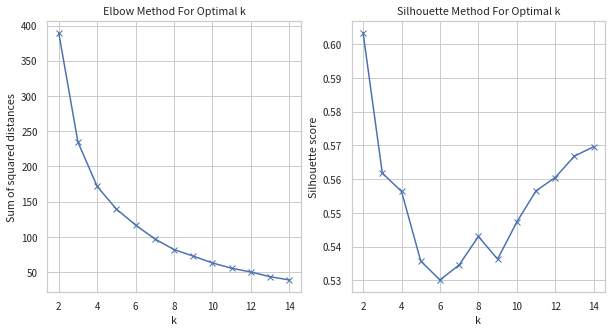

In [4]:
# now look to see if obvious clusters

c = pt.space.cluster()
c.find_k()

Not *great* clustering behaviour here (to be expected, more of a spectrum). Instead lets work backwards, we want a fairly basic breakdown, so lets pick 4.

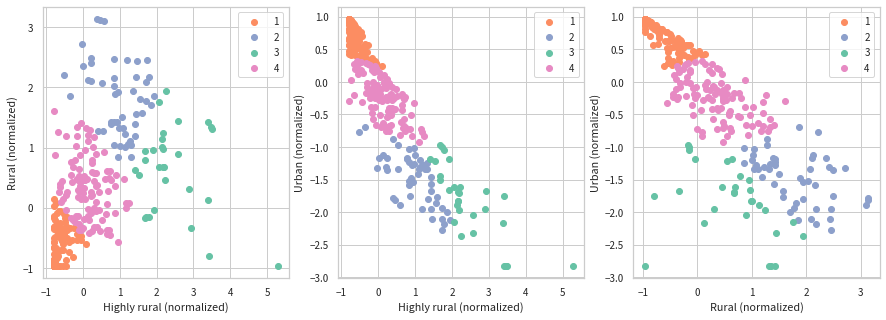

In [5]:
c.set_k(4).plot()

These seem ok grouping (although obviously at the margins the limit is not hard). 

In [6]:
c = c.set_k(4).add_labels({1:"Urban", 3:"Sparse rural", 4: "Sub urban", 2: "Rural"})
c.stats()

,count,%,random members
labels,,,
1: Urban,188,50.3,"[SFT, ABE, NWM, BOL, BGW]"
2: Rural,50,13.4,"[SSO, SNO, DEB, ELN, SEL]"
3: Sparse rural,29,7.8,"[EDN, MRY, SCB, IOS, DGY]"
4: Sub urban,107,28.6,"[BGE, TEI, ESK, SCE, HIN]"


Little bit of a problem here in that the Urban and Sub-urban categories are quite large. How much does that matter if we cross it with our leagues?

In [7]:
pt["cluster"] = c.label_array(include_short=False)

ldf = la.get_la_with_leagues().set_index("local-authority-code")
ldf = ldf.join(pt, how="outer")

ldf.reset_index().pivot_table("local-authority-code", index="league-group", columns="cluster", aggfunc="count").fillna(0)

cluster,Rural,Sparse rural,Sub urban,Urban
league-group,,,,
District councils,39.0,10.0,68.0,64.0
Northern Ireland,0.0,5.0,5.0,1.0
Single tier,11.0,14.0,34.0,123.0


Assuming we ignore it for Northern Ireland, The Urban single tier is quite large. But also probably quite similar, so seems ok? No need to artifically split big numbers when they're naturalish.

Final question is how does this match up against the official measures?

## Comparing to E/W RUC

The Scotland one isn't avaliable as a one off value. 

In [8]:
ewruc = pd.read_csv(Path("data", "source", "RUC_LAD_2011_EN_LU.csv"))

ewruc = ewruc.la.create_code_column(from_type="gss", source_col="LAD18CD", set_index=True)

combo = ewruc[["Broad RUC11", "RUC11"]].join(pt[["cluster"]])

pd.crosstab(index=combo["Broad RUC11"], columns=combo["cluster"]).common.row_percentages().style.format(percentage_1dp)

cluster,Rural,Sparse rural,Sub urban,Urban
Broad RUC11,,,,
Predominantly Rural,51.2%,15.0%,33.8%,0.0%
Predominantly Urban,0.0%,0.0%,5.7%,94.3%
Urban with Significant Rural,4.3%,0.0%,85.1%,10.6%


This seems pretty good. Going to adapt the category names slightly. 

In [9]:
c = c.set_k(4).add_labels({1:"Urban", 3:"Sparse and rural", 4: "Urban with rural areas", 2: "Rural"})
c.stats()

,count,%,random members
labels,,,
1: Urban,188,50.3,"[CHE, EPS, BAI, HIL, DAR]"
2: Rural,50,13.4,"[ECA, SNO, NEA, WOX, COT]"
3: Sparse and rural,29,7.8,"[MAV, BRE, TOR, FOE, HLD]"
4: Urban with rural areas,107,28.6,"[FLN, COL, FYL, FIF, MEL]"


In [12]:
pt["ruc_cluster"] = c.label_array(include_short=False)
final = pt.reset_index()[["local-authority-code",  "ruc_cluster"]]
final.to_csv(Path("data", "outputs", "ruc_cluster.csv"), index=False)